In [726]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

%matplotlib inline

In [727]:
# Get in dataset
data_features_test = pd.read_csv("datasets/energy-informatics-2020/csvDataFeaturesTest.csv", sep=";")

# Take out only data corresponing to attacks and remove the column labelling it as an attack
data_features_attacks = data_features_test.to_numpy()[238279:, :-1]
print(np.count_nonzero(np.isnan(data_features_attacks)))
# Set negative values to 0
data_features_attacks = np.where(data_features_attacks >= 0, data_features_attacks, 0)
data_features_attacks = data_features_attacks.reshape((9999,21,1)).astype('float32')

0


In [728]:
# based on Austrian dataset
batch_size = 21
features = 21
# what is sequence length actually representing here
seq_length = 5

In [729]:
# shuffle prevents model from getting stuck in local minima when solving the loss function
train_dataset = (tf.data.Dataset.from_tensor_slices(data_features_attacks[:9000]).shuffle(10000).batch(batch_size))

In [730]:
def make_generator_model():
    model = tf.keras.Sequential()
    # LSTM hidden layer with 100 memory units
    model.add(tf.keras.layers.LSTM(100, input_shape = (seq_length, features), recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.LSTM(100, recurrent_dropout=0.4))
    # dropout layer with a probability of 20
    # model.add(tf.keras.layers.Dropout(0.2))
    # output dense (fully connected) layer
    model.add(tf.keras.layers.Dense(features, activation="tanh"))
    return model

In [731]:
generator = make_generator_model()
# what do we want to the generator to output? One packet at a time? One attack at a time?
# what to use as noise - what kind of dimension?
# BGAN does [batch_size x seq_length, features]
# LSTM expects sequences of the form [samples, time steps, features]
noise = tf.random.normal((batch_size, seq_length, features))
generated_data_untrained = generator(noise, training=False)
generated_data_untrained.get_shape()

TensorShape([21, 21])

In [732]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(100, input_shape=(21,1), recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.LSTM(100, recurrent_dropout=0.4))
    # model.add(tf.keras.layers.Dropout(0.2))
    # what should the units of this dense layer be?
    # seems like it outputs one value >0 for real data and <0 for fake data
    # for each item in the batch
    model.add(tf.keras.layers.Dense(1, activation="tanh"))
    return model

In [733]:
discriminator = make_discriminator_model()
decision_untrained = discriminator(generated_data_untrained)
decision_untrained

<tf.Tensor: shape=(21, 1), dtype=float32, numpy=
array([[ 8.2598178e-04],
       [ 8.3120831e-06],
       [-1.9348513e-04],
       [ 4.4348193e-04],
       [ 2.5758974e-04],
       [-2.7169308e-04],
       [ 5.8096204e-05],
       [-1.0436410e-03],
       [-1.2568595e-04],
       [-2.3496206e-04],
       [-3.2084994e-05],
       [-6.9115782e-04],
       [ 4.2423175e-04],
       [-3.0908617e-04],
       [ 2.8723245e-04],
       [-2.5736677e-04],
       [-2.1951633e-04],
       [ 6.6993700e-04],
       [-1.2085278e-03],
       [-6.0254493e-04],
       [-2.7193275e-04]], dtype=float32)>

### Binary Cross Entropy

$$ H_p(q) = -\frac{1}{N} \Sigma_{i=1}^N y_i log(p(y_i)) + (1-y_i) log(1-p(y_i)) $$

### BGAN Losses

$$ D_{loss} = \frac{1}{m} \Sigma_{i=1}^m [logD(x_i) + log(1-D(G(z_i)))] $$

$$ G_{loss} = \frac{1}{m} \Sigma_{i=1}^m [log(1-D(G(z_i)))] $$

In [734]:
# define losses (this will change)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) # from_logits=True means models prediction represents a value [-inf, inf]

In [735]:
def discriminator_loss(real_data, fake_data):
    real_loss = cross_entropy(tf.ones_like(real_data), real_data)
    fake_loss = cross_entropy(tf.zeros_like(fake_data), fake_data)
    total_loss = real_loss + fake_loss
    return total_loss

    # BGAN loss
    # loss = tf.reduce_mean(tf.math.log(real_data) + tf.math.log(1 - fake_data), axis=None)
    # if tf.math.is_nan(loss):
    #     return 0.0
    # return loss

In [736]:
def generator_loss(fake_data):
    return cross_entropy(tf.ones_like(fake_data), fake_data)

    # BGAN loss
    # loss = tf.reduce_mean(tf.math.log(1 - fake_data))
    # if tf.math.is_nan(loss):
    #     return 0.0
    # return loss

In [737]:
generator_optimiser = tf.keras.optimizers.Adam(1e-4)
discriminator_optimiser = tf.keras.optimizers.Adam(1e-4)

In [738]:
@tf.function
def train_step(data):
    dlosses = []
    glosses = []
    # generate samples from the random space
    noise = tf.random.normal((batch_size, seq_length, features))

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_data = generator(noise, training=True)

        real_data = discriminator(data, training=True)
        fake_data = discriminator(generated_data, training=True)

        gloss = generator_loss(fake_data)
        dloss = discriminator_loss(real_data, fake_data)
        dlosses.append(dloss)
        glosses.append(gloss)

    generator_gradients = generator_tape.gradient(gloss, generator.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(dloss, discriminator.trainable_variables)

    generator_optimiser.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimiser.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return dloss, gloss

In [739]:
noise = tf.random.normal((batch_size, seq_length, features))

In [740]:
epochs = 30

In [741]:
def train(dataset, epochs):
    predictions = np.array([])
    dlosses = []
    glosses = []

    for epoch in range(epochs):
        
        # maybe add another loop for more training rounds
        for data_batch in dataset:
            dloss, gloss = train_step(data_batch)
            dlosses.append(dloss)
            glosses.append(gloss)

        prediction = generator(noise, training=False)
        predictions = np.append(predictions, prediction)

    return predictions, dlosses, glosses

In [742]:
preds, dlosses, glosses = train(train_dataset, epochs=epochs)

In [743]:
preds.shape
preds = preds.reshape(batch_size*epochs, features)

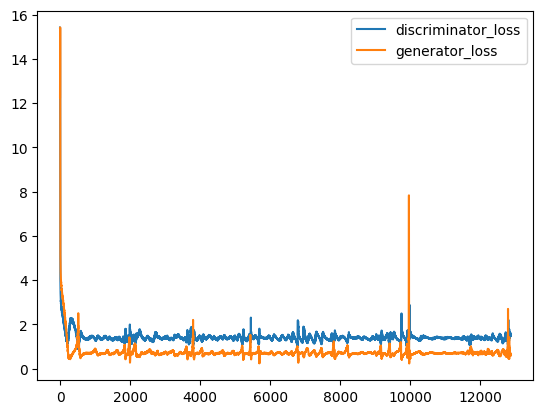

In [744]:
plt.plot(dlosses, label="discriminator_loss")
plt.plot(glosses, label="generator_loss")
plt.legend()

In [745]:
# when I increase memory units the losses go insane
# smoother losses using tanh for both losses and non-logit binary crossentropy
# not adding dropout genuinely makes it go insane

In [746]:
preds[-100:, :], preds.shape

(array([[-0.39861131, -0.1124873 ,  0.32606789, ...,  0.26103678,
          0.49471718, -0.14399335],
        [-0.33614802,  0.04368205,  0.36549655, ...,  0.23553172,
          0.37349218, -0.00366266],
        [-0.37716252, -0.17571776,  0.34698686, ...,  0.18118268,
          0.50298083, -0.10435598],
        ...,
        [-0.43542975, -0.19706275,  0.53271377, ...,  0.02429573,
          0.36504686, -0.15212283],
        [-0.50899738,  0.05130783,  0.52831388, ...,  0.00443929,
          0.32643467, -0.43055129],
        [-0.50821042, -0.07539355,  0.56148005, ...,  0.01247329,
          0.38048816, -0.28079548]]),
 (630, 21))